# A Multiplicity of Models

We haven't really talked too much about specific models or algorithms, that is something you can study on your own, but a warning -- that liteature is extensive, so I'd suggest starting with YouTube videos. 

In general you might approach a given classification or regression problem with a number of different possible models to determine which is the most useful for your purposes (e.g., most accurate, least biased, etc.). A few potential models (*not exhaustive*) are listed below based on the type of problem they can solve:

* **Classification**: Logistic Regression, K Nearest Neighbors, Support Vector Machines, Random Forest, Neural Networks
* **Regression**: Linear Regression, Polynomial Regression, Stochastic Gradient Descent, Support Vector Machines, Random Forest, Neural Networks

In this notebook, you will work with synthesized data to understand the workflow for using and comparing classifiers. Along the way, we will introduce new models, but only link to videos that explain what they do.

---
## 0. Today's Initial Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification, make_circles
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, roc_auc_score

%matplotlib inline

---
## 1. Example: Validating a Logistic Regression Model

We will start with a Logistic Regression Model and synthesized data. 

[[Logistic Regression Explained]](https://www.youtube.com/watch?v=yIYKR4sgzI8) *(No need to watch in class.)*

By reviewing and working with this example, you should be able to identify and explain the different ways in which we are validating the Logisitc Regression model. 

### 1.1 Making classification data

We start by making the data using the `make_classification()` method. I will pick 1000 samples with 20 features; only 4 of them will be informative about the 2 classes. What `make_classification()` returns are the data (the features for the model) and the class labels (the 1 or 0). For simplicity and familiarity, I convert them both to `pandas` data frames as this is typically what you would do with data you read in.

In [2]:
## Parameters for making data
N_samples = 1000
N_features = 20
N_informative = 4
N_classes = 2

## Make up some data for classification
X, y = make_classification(n_samples = N_samples,
                           n_features = N_features,
                           n_informative = N_informative,
                           n_classes = N_classes)

## Store the data in a data frame
feature_list = []

for feature in np.arange(N_features):
    feature_list.append('feature_'+str(feature))

features = pd.DataFrame(X, columns=feature_list)
classes = pd.DataFrame(y, columns=['label'])

We can check the `.head()` of both data frames to make sure we know what we imported.

In [3]:
features.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
0,-1.098192,1.862668,-0.820336,0.923235,-1.635116,3.033266,1.102672,1.109371,-0.636963,-0.530607,-2.724995,1.051503,1.275838,1.415821,-1.437744,0.430579,1.396506,-0.415690,1.048429,0.539890
1,-1.494346,0.239000,0.159170,-1.739487,0.467913,-2.804456,0.242897,-1.316452,-1.021794,-0.717969,-0.716208,-0.423315,3.524573,0.509658,-0.426725,-0.558559,-3.312709,0.387138,0.876832,-0.466315
2,-0.215303,1.544691,0.104928,1.406746,-0.382356,1.751891,2.249555,-1.385713,-2.248036,0.758376,-1.142591,-0.663332,-1.225332,-3.673697,0.431339,0.485051,-3.084321,0.284271,0.050322,0.726006
3,-0.481681,0.129601,-0.193861,0.771522,-0.803537,2.256499,-0.688190,-0.116758,-0.264766,1.278449,0.149068,0.705688,-0.253244,-0.892780,0.198981,-0.327501,0.016289,-0.917160,0.153633,0.050391
4,0.054113,-0.671382,0.463920,0.330192,0.186946,0.073881,1.024527,-0.154406,-0.636621,0.469392,0.600108,1.400121,1.086765,-0.118856,2.480812,0.708082,-1.559310,-0.240415,-0.336196,1.601558


In [4]:
classes.head()

,label
0,1
1,0
2,0
3,0
4,0


### 1.2 Plotting Feature Spaces

We've found that looking at the classes in some feature subspace has been helpful in seeing if there are subspaces where the classes are more separated. We do this so frequently, it is worth having a little piece of code to do that. I've written one below.

In [5]:
def PlotFeatureSpace(x1,x2,c):
    
    '''From a Data Series, PlotFeatureSpace creates a 
    scatter plot of two features and colors the dots 
    using the classes. The figure labels are the names 
    of each passed column of the Data Series.'''
    
    plt.figure()
    plt.scatter(x1, x2, c=c)
    plt.xlabel(x1.name);
    plt.ylabel(x2.name);

<font size=+3>&#9998;</font> **Do this:** Using PlotFeatureSpace(), try to find at least two possible features that might be important to the model. That is, can you find two features that seperate the classes well? I've given an example call below.

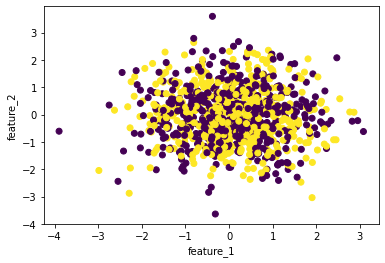

In [6]:
## Parameters for PlotFutureSpace

x = "feature_1"
y = "feature_2"
c = classes['label']

PlotFeatureSpace(features[x], features[y], c)

<font size=+3>&#9998;</font> **Do this:** Which two features did you find? Keep note here! 

*If you rerun the data creation process, the same two features might no longer be useful.*

<font size=+3>&#9998;</font> **Do this:** Erase this and write here.

### 1.3 A Logistic Regression Model

As we did with KNN, we will train and test a classification model. This time it will be a [Logitstic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model. We will first use the confusion matrix to determine how things are going. I've written to code below to split the data, create the model, fit it, and predict the classes of the test data.

In [7]:
## Split the data
x_train, x_test, y_train, y_test = train_test_split(features, classes)

## Create an instance of the model (LR with no regularization)
model = LogisticRegression(penalty='none')

## Fit the model to the training data
model.fit(x_train, y_train['label'])

## Use that model to predict test outcomes
y_pred = model.predict(x_test)

## Compare the real outcomes to the predicted outcomes
print(confusion_matrix(y_test, y_pred))

[[101  38]
 [ 15  96]]


#### 1.3.1 The Metric Zoo

There are many different ways to use the confusion matrix to determine different qualities of your classifier. Accuracy, the number of true positives and negatives comapred to all predictions is just one of these metrics. There's a lot of them! [[Wikipedia article on evaluation metrics]](https://en.wikipedia.org/wiki/Confusion_matrix)

Two of the more important ones are the accuracy (as we've used before) and the [f1-score](https://en.wikipedia.org/wiki/F-score) (closer to 1 is better). The `sklearn` toolkit has all these built-in, but one tool that is at the ready is `classification_report()`, which gives the accuracy, the f-1 score, as well as the [precision](https://en.wikipedia.org/wiki/Positive_and_negative_predictive_values) and [recall](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) -- two other common metrics for evaluation.

Once we have predicted class labels, then we can use `classification_report`. Both the `confusion_matrix` and `classification_report` can be used with any of `sklearn`'s classifiers.

In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.73      0.79       139
           1       0.72      0.86      0.78       111

    accuracy                           0.79       250
   macro avg       0.79      0.80      0.79       250
weighted avg       0.80      0.79      0.79       250



### 1.4 AUC and the ROC Curve

The Receiver Operator Characteristic (ROC) Curve and the associated Area Under the Curve (AUC) are additional tools that help us validate our model. Fortunately, `sklearn` has `roc_curve`, that will return to quantities needed to plot this curve. The AUC can also be determined using the built in `roc_auc_score()` method.

Below I wrote a little bit of code to plot the ROC curve and compute the AUC for this model. 

Again, both of the tools are available for any classifier model.

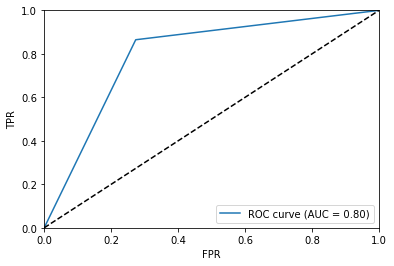

In [9]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure()

plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc_score(y_test,y_pred))
plt.plot([0, 1], [0, 1], c='k', linestyle='--')

plt.axis([0, 1, 0, 1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc="lower right")

### 1.5 Model Specific Tools - Logistic Regression

A LR model uses a transformed linear model to fit the data. It predicts numerical weights for each feature in the data. Those numerical weights can be converted to odds ratio by exponentiating them:

$odds_i = \exp(\beta_i)$

where $\beta_i$ is the numerical weight for the $i$th feature determined by the model. In `sklearn` speak, these would be "coefficients" of the model; `coef_` in code (and yes with the trailing underscore). The nice thing about LR is that these coefficients are typically interpretable. That is if the odds of a feature is close to one then that feature has virtually no effect on the model. On the other hand, if a feature is much larger than one, we find that might contribute a lot to the model.

In this case, we'd expect that feature to be useful in separating the two class labels. *That is why you predicted two features earlier!*

Below I wrote a little code to find those odds ratios. 

In [10]:
## Extract model coefficeints
print("Model Coefficients:", model.coef_)

## Compute odds ratios from model coefficients
odds = np.exp(model.coef_.ravel())
print("Odds Ratios:", odds)

Model Coefficients: [[-0.02066238  0.04384379 -0.12961906 -0.70813244 -0.05648027 -0.03975368
  -0.08404495 -0.26998316  0.05766125  0.0461145   0.07626382  0.11417335
  -0.01014345  0.1069069  -0.07461901  0.08627959  0.80801539 -0.02552695
  -0.0454346   0.0338424 ]]
Odds Ratios: [0.97954962 1.04481913 0.87842999 0.49256323 0.94508513 0.96102613
 0.91938993 0.76339235 1.05935607 1.04719431 1.07924727 1.12094642
 0.98990783 1.11283065 0.92809702 1.09011107 2.24345118 0.97479611
 0.9555821  1.03442157]


<font size=+3>&#9998;</font> **Do this:** Make a bar plot of the odds ratios. Which ones appear to contribute to the model? Are any of them the two featurs you found earlier? You can use `Plot_Feature_Space()` to confirm.

In [11]:
## your code here

### 1.5 Monte Carlo Validation

One of the important things about machine learning is that it often relies on the randomness of the draw of training and testing sets. As a result, any  one time the model is run you are working with a particualr choice of data for training and testing. Thus, there's a problem in reporting the results of a single model because it depends on the curiousities of what was drawn in the first place!

One of the ways we validate the model we have used is to determine how representative our one run is compared to a large number of runs. Ideally, we'd like to know what the disitrbution of possible results could be. That allows us to put some error bounds on the estimated model parameters and to explain the confidence we have in our approach and results.

There's two main types of validation, although many others exist and there's nuance inside of each:

* **Cross-Validation:** The algorithm slices the data in N bins. Then it treats each bin in turn as a test set using the reamining N-1 bins as the training data. *This approach and modifications to it are part of `sklearn`.* [Cross Validation Documentation](https://scikit-learn.org/stable/modules/cross_validation.html)
* **Monte Carlo Validation:** This is relatively simple as you simply repslit the data and run the model again and collect the results. **This is the approach we will use in this notebook.**

Below, I wrote a short function that splits the data, creates the model, fits it, and returns the evaluation metrics including the model weights. The lines below runs it.

In [12]:
def RunLR(features, classes, penalty='none'):
    
    '''RunLR runs a logisitic regression model with 
    default splitting. It returns evalaution metrics including
    accuracy, auc, and the model coefficients.'''
    
    x_train, x_test, y_train, y_test = train_test_split(features, classes)
    LR = LogisticRegression(penalty=penalty)
    LR.fit(x_train, y_train)
    y_pred = LR.predict(x_test)
    
    return accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred), LR.coef_

In [13]:
acc, auc, model_coefs = RunLR(features, classes['label'])
print("Accuracy: ", acc)
print("AUC:", auc)
print("Coefs:", model_coefs)

Accuracy:  0.728
AUC: 0.7283666154633897
Coefs: [[-0.11143153  0.03724794 -0.03295985 -0.8124892  -0.06162852 -0.14842235
  -0.10550263 -0.33206745 -0.09438157  0.1316189   0.10546192  0.17252506
   0.02304705  0.10174161 -0.11080682 -0.00249266  0.79716605 -0.07876609
  -0.06500562  0.04170595]]


<font size=+3>&#9998;</font> **Do this:** Write a loop that does Monte Carlo Validation with 100 trials using `RunLR()`. Make sure to store the accuracy and auc each time the loop runs - you will want to know how these are distributed. 

*You can also try to store the model coefficients, but that isn't necessary to understand what we are trying to do. And it might lead to shape mismatch issues that aren't worth debugging right now*

In [14]:
## Your code here

<font size=+3>&#9998;</font> **Do this:** Now that you have the distribution of accuracy scores and auc, let's compute the mean, standard deviation, and plot them as historgrams. Do you notice anything about the shape of the histograms?

In [15]:
## your code here

---
## 2. Parameter Tuning

Great! Now that we have seen how we can explore our confidence in the model we created, we can now determine if indeed we have the best logisitc regression model we could have. There's a number of parameters that the logisitic regression method can take when you create an instance. Each of them control different aspects of how the model fits.

For our purposes, we will just explore if it was ok to use no penalization. Penalization is how a logistic regression model might control for variables that don't matter too much. Penalization tends to shrink model coefficients towards zero if they are small, so it's clear what contributes and what doesn't. 

To do a little paramter testing we will use `GridSearchCV()`. The method basically wraps any class to a classifier (or regressor) and then lets you tell it, please try all these potential versions. For example, we have four choices of penalization `l1`, `l2`, `elasticnet` (which is `l1` and `l2` at the same time), and `none` (which we have used all along). So we can test all four models simulatneously to see which is the best.

I wrote a little code that does that. Notice that `parameters` is basically a set where `penalty` is the variable for the model and the list that follows indicates that type of penalty to try. Once you run `.fit()` the models start being built. Notice combinations of parameters that can't work together will throw warnings (this is normal, but you should chck other warnings!).

In [16]:
parameters = [
    {'penalty': ['l1', 'l2', 'elasticnet', 'none']},
]

LR_tuned = LogisticRegression()
clf = GridSearchCV(LR_tuned, parameters)
clf.fit(features, classes['label'])

/Users/caballero/opt/anaconda3/envs/ml-short-course/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/caballero/opt/anaconda3/envs/ml-short-course/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/caballero/opt/anaconda3/envs/ml-short-course/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/caballero/opt/anaconda3/envs/ml-short-course/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 

GridSearchCV(estimator=LogisticRegression(),
             param_grid=[{'penalty': ['l1', 'l2', 'elasticnet', 'none']}])

At the end of all this, we get call back with the parameter grid we created. Notice that if we had another parameter to set, `GridSearchCV` will try to run all parameter combinations. So that each new parameter is multiplicative leading to many models quite fast. So be careful here!

For example, consider we had three paramters, one that had two settings, one with three, and one with five. If you call a grid search with these paramters, you will be asking `sklearn` to create an run 2x3x5 models (30 models). If you have another parameter you want to try that has another 4 settings, you are up to 120 models!

### 2.1 Results of a Grid Search

In any event, after running this, we can find the `best_estimator_` and the `best_score_`. The `best_estimator` is the call you should use for the best model tested. If any settings are the default, they will not appear in the parentheses. The `best_score_` is the accuracy of that model. Of course, you can get more details (like above) if you choose that best model and run it through Monte Carlo validation.

In [17]:
print(clf.best_estimator_)
print(clf.best_score_)

LogisticRegression(penalty='none')
0.77


### 2.2 What about other classifiers?

There are many other classifers we can try on the same problem to see how well they do. There's many out there and there's lots of nuance to understand about each if you are going to use them. We will use K Nearest Neighbors, Supprt Vector Machines, and a Random Forest Classifier. To learn more about each, I'd suggest these videos:

* [KNN](https://www.youtube.com/watch?v=HVXime0nQeI)
* [SVM](https://www.youtube.com/watch?v=efR1C6CvhmE)
* [Random Forest](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ)

Let's import the necessary libraries and test things with KNN. Then you can write code for the Support Vector Machine, and the Random Forest.

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

#### 2.2.1 KNN

As we did previously we can vary the number of neighbors from the default of 5 (always good to know the defaults of the models you are calling). But this time we will use `GridSearchCV`. I've written the code to do this below. You can adapt it for other models in the next sections as you like.

In [19]:
## Sweep through 2 to 20 neighbors

parameters = [
    {'n_neighbors': np.arange(2,21)}
]

## Create the Grid Search and fit it
KNN_tuned = KNeighborsClassifier()
clf = GridSearchCV(KNN_tuned, parameters)
clf.fit(features, classes['label'])

## Determine the best estimator
BestKNN = clf.best_estimator_
print(BestKNN)
print(clf.best_score_)

KNeighborsClassifier(n_neighbors=8)
0.874


We can now use the best model to do Monte Carlo Validation and plot the distributions.

In [20]:
def RunKNN(features, classes):
    
    x_train, x_test, y_train, y_test = train_test_split(features, classes)
    KNN = BestKNN
    KNN.fit(x_train, y_train)
    y_pred = KNN.predict(x_test)
    
    return accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred)

RunKNN(features, classes['label'])

(0.872, 0.8733974358974359)

Mean Accuracy: 0.8624266666666667 +/- 0.017450251828810076
Mean AUC: 0.8626038342309603 +/- 0.01755494551707241


Text(0.5, 0, 'AUC')

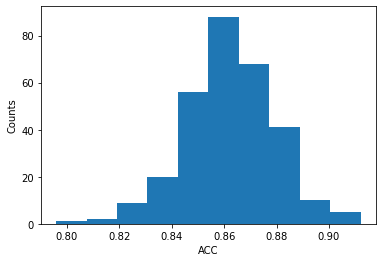

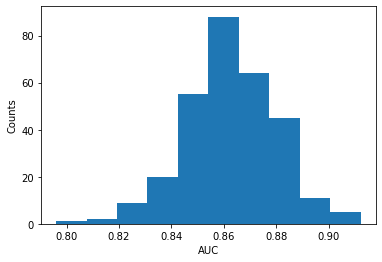

In [21]:
N = 300
acc = 0
auc = 0
acc_array = np.empty((0,N), float)
auc_array = np.empty((0,N), float)

for i in range(N):
    
    acc, auc = RunKNN(features, classes['label'])
    acc_array = np.append(acc_array,acc)
    auc_array = np.append(auc_array,auc)
    
    
mean_acc = np.mean(acc_array)
std_acc = np.std(acc_array)

mean_auc = np.mean(auc_array)
std_auc = np.std(auc_array)
    
plt.figure()
plt.hist(acc_array)
print("Mean Accuracy:", mean_acc, "+/-", std_acc)
plt.ylabel('Counts')
plt.xlabel('ACC')

plt.figure()
plt.hist(auc_array)
print("Mean AUC:", mean_auc, "+/-", std_auc)
plt.ylabel('Counts')
plt.xlabel('AUC')

#### 2.2.2 LinearSVC

<font size=+3>&#9998;</font> **Do this:** For the `LinearSVC()` model, repeat the work above to determine the distribution of accuracies and aucs for the model. Use `GridSearchCV()` to vary the `C` parameter and find the best model. [Linear SVC Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

In [22]:
### your code here

#### 2.2.3 Random Forest

<font size=+3>&#9998;</font> **Do this:** For the `RandomForestClassifier()` model, repeat the work above to determine the distribution of accuracies and aucs for the model. Use `GridSearchCV()` to vary the `n_estimators` parameter and find the best model. [Random Forest Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [23]:
## your code here

---
## 3. What about other kinds of data?

Many times it is important to know the strucutre of your data, hence plotting feature spaces. Sometimes the models you are using might be incompatible with the structure of your data. Some models try to draw lines to separate, some draw curves, some are more emergent. Let's test this out with a ciruclar data set where we can clearly see the separation. Below, we create some data and store the values in data frames.

In [24]:
X, y = make_circles(n_samples = 500)

loc = pd.DataFrame(X, columns=['x1','x2'])
label = pd.DataFrame(y, columns=['y'])

In [25]:
loc.head()

,x1,x2
0,-0.425779,0.904827
1,0.710509,0.367664
2,-0.888136,0.459580
3,0.149905,-0.785830
4,-0.010053,-0.799937


In [26]:
label.head()

,y
0,0
1,1
2,0
3,1
4,1


### 3.1 Plot it! 

Let's plot this data to see why we might not expect the same results as we had found for the previous case.

Text(0, 0.5, 'x2')

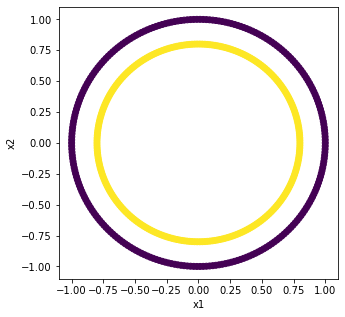

In [27]:
plt.figure(figsize=(5,5))
plt.scatter(loc['x1'], loc['x2'], c=label['y'])
plt.xlabel('x1')
plt.ylabel('x2')

It is really easy to see in the figure above that we have two clearly separated classes. Let's fire up the Logisitic Regression model and see what it can find.

In [28]:
parameters = [
    {'penalty': ['l1', 'l2', 'elasticnet', 'none']},
]

LR_tuned = LogisticRegression()
clf = GridSearchCV(LR_tuned, parameters)
clf.fit(loc, label['y'])

LRBest = clf.best_estimator_
print(LRBest)
print(clf.best_score_)

LogisticRegression()
0.46399999999999997


/Users/caballero/opt/anaconda3/envs/ml-short-course/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/caballero/opt/anaconda3/envs/ml-short-course/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/caballero/opt/anaconda3/envs/ml-short-course/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/caballero/opt/anaconda3/envs/ml-short-course/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 

### 3.2 Time to try other models

It appears the the logistic regression does pretty poorly. That is because logistic regression is not good with nonlinear problems. It is a linear model, so it's hard for it to deal with things like circles!

<font size=+3>&#9998;</font> **Do this:** Test the SVC, KNN, and RF models on these data. Use `GridSearchCV()` to find the best model for each. How do the accuracies compare? Which might you use to work more on this problem? *No need to plot disitrbutions for this, you can do that later if you like.*

In [29]:
### your code here

### 3.3 Let's make the data a bit messier.

You probably found that one model worked perfectly. We can add a little noice to make things more interesting.

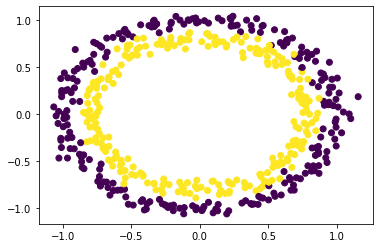

In [30]:
X, y = make_circles(n_samples = 500, noise = 0.05)

loc = pd.DataFrame(X, columns=['x1','x2'])
label = pd.DataFrame(y, columns=['y'])

plt.scatter(loc['x1'], loc['x2'], c=label['y'])

### 3.4 Try to find the best model for this data

<font size=+3>&#9998;</font> **Do this:** Test the LR, SVC, KNN, and RF models on these data. Use `GridSearchCV()` to find the best model for each. How do the accuracies compare? Which might you use to work more on this problem? *No need to plot disitrbutions for this, you can do that later if you like.*

In [31]:
## your code here